<a href="https://colab.research.google.com/github/asutoshgha/MLtutorials/blob/main/18bcs014EDAAssigment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Dec 10 17:05:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    37W / 250W |    511MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

%matplotlib inline

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

In [ ]:
print(check_output(["ls", "/content/drive/MyDrive/Datasets"]).decode("utf8"))

archive.zip
Flickr8k
ml-100k



In [ ]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('/content/drive/MyDrive/Datasets/ml-100k/u.user', sep='|',
                    names=u_cols,encoding='latin-1', parse_dates=True)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('/content/drive/MyDrive/Datasets/ml-100k/u.data', sep='\t',
                      names=r_cols,encoding='latin-1')

m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('/content/drive/MyDrive/Datasets/ml-100k/u.item', sep='|',
                     names=m_cols, usecols=range(5),encoding='latin-1')

movie_ratings = pd.merge(movies, ratings)
df = pd.merge(movie_ratings, users)

df.head()
#df.head(2)

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,60,M,retired,95076


In [ ]:
ratings.head(1)

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949


In [ ]:
movies.head(1)

,movie_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...


In [ ]:
users.head(1)

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711


Data Preprocessing

In [ ]:
df.drop(df.columns[[3,4,7]], axis=1, inplace=True)
ratings.drop( "unix_timestamp", inplace = True, axis = 1 ) 
movies.drop(movies.columns[[3,4]], inplace = True, axis = 1 )
#Dropping all the columns that are not really needed
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   movie_id      100000 non-null  int64 
 1   title         100000 non-null  object
 2   release_date  99991 non-null   object
 3   user_id       100000 non-null  int64 
 4   rating        100000 non-null  int64 
 5   age           100000 non-null  int64 
 6   sex           100000 non-null  object
 7   occupation    100000 non-null  object
 8   zip_code      100000 non-null  object
dtypes: int64(4), object(5)
memory usage: 7.6+ MB


Movie Ratings

In [ ]:
movie_stats = df.groupby('title').agg({'rating': [np.size, np.mean]})
movie_stats.head()

rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000
101 Dalmatians (1996)        109  2.908257
12 Angry Men (1957)          125  4.344000
187 (1997)                    41  3.024390

**Setting a threshold of atleast 50 ratings for better analysis.**

In [ ]:
min_50 = movie_stats['rating']['size'] >= 50
movie_stats[min_50].sort_values([('rating', 'mean')], ascending=False).head()

rating          
                                                     size      mean
title                                                              
Close Shave, A (1995)                                 112  4.491071
Schindler's List (1993)                               298  4.466443
Wrong Trousers, The (1993)                            118  4.466102
Casablanca (1942)                                     243  4.456790
Wallace & Gromit: The Best of Aardman Animation...     67  4.447761

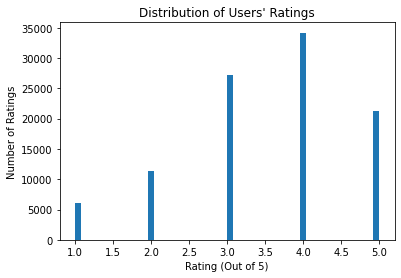

In [ ]:
ratings.rating.plot.hist(bins=50)
plt.title("Distribution of Users' Ratings")
plt.ylabel('Number of Ratings')
plt.xlabel('Rating (Out of 5)');

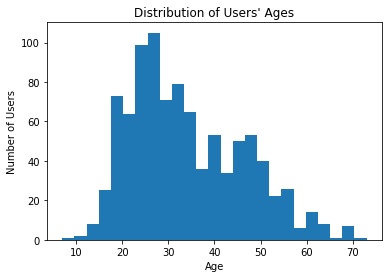

In [ ]:
users.age.plot.hist(bins=25)
plt.title("Distribution of Users' Ages")
plt.ylabel('Number of Users')
plt.xlabel('Age');

In [ ]:
ratings_matrix = ratings.pivot_table(index=['movie_id'],columns=['user_id'],values='rating').reset_index(drop=True)
ratings_matrix.fillna( 0, inplace = True )
ratings_matrix.head()

user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943
0,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,1.0,5.0,4.0,5.0,0.0,3.0,5.0,0.0,5.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,4.0,3.0,3.0,4.0,0.0,3.0,5.0,3.0,5.0,0.0,0.0,5.0,0.0,3.0,3.0,0.0,4.0,3.0,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
1,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,5.0,5.0,0.0,0.0,5.0,0.0,3.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cosine Similiarity

In [ ]:
#movie_similarity = 1 - pairwise_distances( ratings_matrix.as_matrix(), metric="cosine" )
#np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
#ratings_matrix = pd.DataFrame( movie_similarity )
#ratings_matrix.head(5)
movie_similarity = 1 - pairwise_distances( ratings_matrix.values, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix = pd.DataFrame( movie_similarity )
ratings_matrix.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,0.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,0.468291,0.460392,0.417509,0.347678,0.574377,0.224120,0.273916,0.046232,0.191772,0.232930,0.339196,0.527169,0.338105,0.467598,0.567950,0.227295,0.208472,0.592877,0.361657,0.150959,0.439441,0.259257,0.288536,0.090654,0.136757,0.108560,0.069805,0.368420,0.278386,0.246123,...,0.065390,0.010550,0.023592,0.014155,0.023592,0.023592,0.023592,0.023592,0.023592,0.014226,0.0,0.058979,0.047183,0.032856,0.035387,0.048189,0.058979,0.058979,0.035387,0.0,0.0,0.067404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033363,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
1,0.402382,0.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,0.468506,0.459946,0.213972,0.125463,0.253162,0.098185,0.390438,0.113063,0.030692,0.091550,0.319308,0.483349,0.278182,0.434907,0.306639,0.206481,0.408737,0.483077,0.581119,0.089355,0.462797,0.160738,0.479187,0.072342,0.087347,0.215247,0.184592,0.562970,0.334570,0.256668,...,0.049324,0.035017,0.078299,0.046980,0.078299,0.078299,0.078299,0.078299,0.078299,0.000000,0.0,0.000000,0.078299,0.000000,0.104399,0.000000,0.000000,0.000000,0.104399,0.0,0.0,0.074571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055366,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
2,0.330245,0.273069,0.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,0.361165,0.319295,0.271402,0.190242,0.266335,0.167609,0.404239,0.126564,0.105377,0.187733,0.194546,0.293732,0.233814,0.381910,0.306447,0.214125,0.261303,0.269296,0.253074,0.126347,0.259129,0.185187,0.404930,0.179008,0.046315,0.073332,0.051270,0.240534,0.277311,0.176729,...,0.036615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009736,0.0,0.000000,0.096875,0.000000,0.000000,0.000000,0.064583,0.064583,0.096875,0.0,0.0,0.018452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
3,0.454938,0.502571,0.324866,0.000000,0.334239,0.090308,0.489283,0.490236,0.419044,0.252561,0.588337,0.584884,0.397251,0.266764,0.330457,0.169240,0.404889,0.100856,0.129363,0.208262,0.256467,0.572811,0.446568,0.413422,0.422300,0.380248,0.370192,0.531380,0.429785,0.216894,0.480685,0.351676,0.467377,0.127933,0.062932,0.170815,0.143852,0.457528,0.456760,0.331256,...,0.023691,0.016819,0.037609,0.022565,0.037609,0.037609,0.037609,0.037609,0.037609,0.000000,0.0,0.000000,0.056413,0.069838,0.000000,0.000000,0.075218,0.075218,0.000000,0.0,0.0,0.064472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039890,0.000000,0.0,0.094022,0.094022,0.037609,0.0,0.0,0.0,0.056413,0.075218
4,0.286714,0.318836,0.212957,0.334239,0.000000,0.037299,0.334769,0.259161,0.272448,0.055453,0.375809,0.373824,0.196495,0.103288,0.265123,0.112156,0.389191,0.077737,0.088631,0.061197,0.192679,0.319438,0.245088,0.237436,0.284242,0.228855,0.242739,0.326892,0.321288,0.127992,0.338714,0.151706,0.280778,0.110782,0.041288,0.213947,0.058926,0.391974,0.287402,0.272573,...,0.039565,0.028088,0.062807,0.037684,0.062807,0.062807,0.062807,0.062807,0.062807,0.000000,0.0,0.000000,0.094211,0.000000,0.094211,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.053835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.094211


Recommender Engine

In [ ]:
try:
    #user_inp=input('Enter the reference movie title based on which recommendations are to be made: ')
    user_inp="Speed (1994)"
    inp=movies[movies['title']==user_inp].index.tolist()
    inp=inp[0]
    
    movies['similarity'] = ratings_matrix.iloc[inp]
    movies.columns = ['movie_id', 'title', 'release_date','similarity']
    movies.head(2)
    
except:
    print("Sorry, the movie is not in the database!")

In [ ]:
print("Recommended movies based on your choice of ",user_inp ,": \n", movies.sort_values( ["similarity"], ascending = False )[1:10])

Recommended movies based on your choice of  Speed (1994) : 
      movie_id  ... similarity
384       385  ...   0.719504
160       161  ...   0.707567
78         79  ...   0.696583
95         96  ...   0.695556
194       195  ...   0.676778
173       174  ...   0.676664
209       210  ...   0.674811
549       550  ...   0.674143
203       204  ...   0.665776

[9 rows x 4 columns]


In [ ]:
reco = movies.sort_values( ["similarity"], ascending = False )[1:10]

In [ ]:
genres = ['unknown', 'Action', 'Adventure', 'Animation','Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
uitem24 = ['movie_id' , 'movie title' , 'release_date' , 'video_release_date','IMDb_URL']
#uitem24.append(i) for i in genres
#print(uitem24)

In [ ]:
for i in genres:
    uitem24.append(i)

In [ ]:
print(uitem24)

['movie_id', 'movie title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [ ]:
movies_detailed = pd.read_csv('/content/drive/MyDrive/Datasets/ml-100k/u.item',sep='|',names = uitem24, encoding='latin-1')

In [ ]:
movies_detailed.head()

,movie_id,movie title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
movies_detailed = movies_detailed.drop(['video_release_date','IMDb_URL','movie title'],axis = 1)

In [ ]:
merged_df = pd.merge(ratings, users, on='user_id',how='inner')
merged_df = pd.merge(merged_df, movies_detailed, left_on='movie_id',right_on = 'movie_id',how='inner')
merged_df.head()

,user_id,movie_id,rating,age,sex,occupation,zip_code,release_date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,49,M,writer,55105,24-Jan-1997,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,305,242,5,23,M,programmer,94086,24-Jan-1997,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,242,4,42,M,executive,98101,24-Jan-1997,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,234,242,4,60,M,retired,94702,24-Jan-1997,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,63,242,3,31,M,marketing,75240,24-Jan-1997,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
merged_df.drop(['zip_code','release_date','occupation'],axis=1,inplace = True)

In [ ]:
merged_df.head()

,user_id,movie_id,rating,age,sex,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,49,M,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,305,242,5,23,M,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,242,4,42,M,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,234,242,4,60,M,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,63,242,3,31,M,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
merged_df.describe()

,user_id,movie_id,rating,age,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.0000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860,32.969850,0.0001,0.255890,0.137530,0.036050,0.071820,0.298320,0.080550,0.007580,0.398950,0.013520,0.017330,0.053170,0.049540,0.052450,0.194610,0.12730,0.21872,0.093980,0.018540
std,266.61442,330.798356,1.125674,11.562623,0.0100,0.436362,0.344408,0.186416,0.258191,0.457523,0.272144,0.086733,0.489685,0.115487,0.130498,0.224373,0.216994,0.222934,0.395902,0.33331,0.41338,0.291802,0.134894
min,1.00000,1.000000,1.000000,7.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
25%,254.00000,175.000000,3.000000,24.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
50%,447.00000,322.000000,4.000000,30.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
75%,682.00000,631.000000,4.000000,40.000000,0.0000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
max,943.00000,1682.000000,5.000000,73.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000


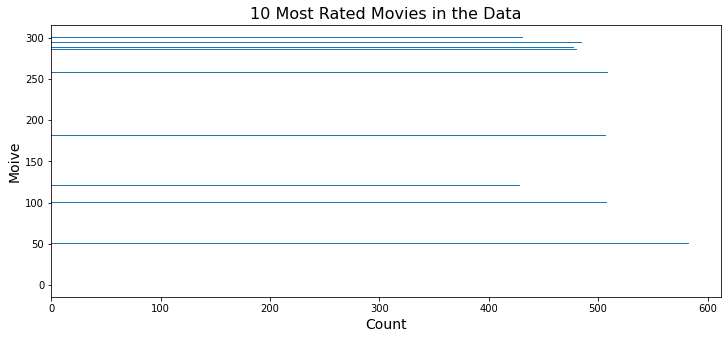

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
top_ten_movies = merged_df.groupby("movie_id").size().sort_values(ascending=False)[:10]
plt.figure(figsize=(12, 5))
plt.barh(y= top_ten_movies.index,width= top_ten_movies.values)
plt.title("10 Most Rated Movies in the Data", fontsize=16)
plt.ylabel("Moive", fontsize=14)
plt.xlabel("Count", fontsize=14)
plt.show()

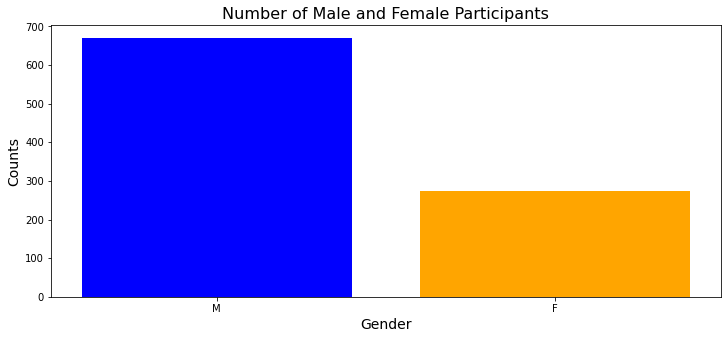

In [ ]:
gender_counts = users.sex.value_counts()

plt.figure(figsize=(12, 5))
plt.bar(x= gender_counts.index[0], height=gender_counts.values[0], color="blue")
plt.bar(x= gender_counts.index[1], height=gender_counts.values[1], color="orange")
plt.title("Number of Male and Female Participants", fontsize=16)
plt.xlabel("Gender", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.show()

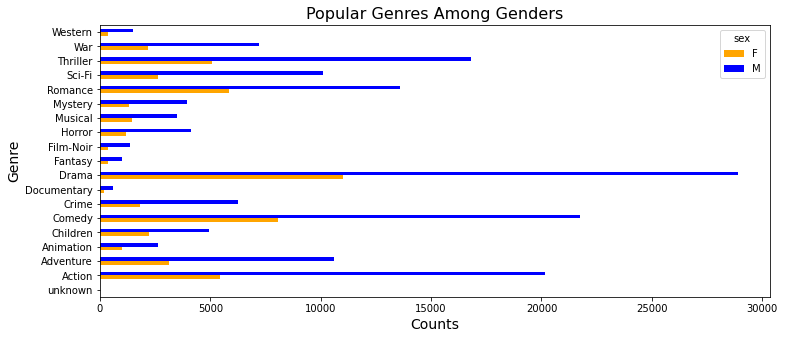

In [ ]:
merged_df[genres+["sex"]].groupby("sex").sum().T.plot(kind="barh", figsize=(12,5), color=["orange", "blue"])
plt.xlabel("Counts",fontsize=14)
plt.ylabel("Genre", fontsize=14)
plt.title("Popular Genres Among Genders", fontsize=16)
plt.show()

In [ ]:
print(genres)
print("Shape of genre list is : 1 x ",len(genres))

['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
Shape of genre list is : 1 x  19
